# This is fruit classification project implementation #3

**Part1: Reading Data**

In [1]:
import cv2
import glob
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import math
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
os.chdir("../input/")
!ls *

fruits:
fruits-360_dataset

realtestdata:
real-data


In [3]:
train_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training/'
test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'

In [4]:
def read_and_preprocess_img(image_path,img_color,img_size):
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    if(img_color == "RGB"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif(img_color == "Gray"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    imResize = cv2.resize(image, dsize=img_size) 
    return imResize.astype("float32")/255

In [5]:
def read_data(path,img_color,img_size):
    data_fruit_img = []
    data_label = []
    for dir_path in glob.glob(path+"/*"):
        img_label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
            image = read_and_preprocess_img(image_path,img_color,img_size)
            data_fruit_img.append(image)
            data_label.append(img_label)
    return (np.array(data_fruit_img),np.array(data_label))

In [6]:
# Read Training data
X_train,train_label = read_data(train_data_dir,"RGB",(100,100))
print(X_train.shape)
print(train_label.shape)

(41322, 100, 100, 3)
(41322,)


**Part2: Reading data with image augmentation**

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=.02,
    height_shift_range=.02,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=1.,
    brightness_range=[0.5, 1.5],
    shear_range=0.8,
    validation_split = .25
)

test_datagen = ImageDataGenerator(rescale=1. / 255)
batch_size_train = 128
batch_size_valid = 128

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_train,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_valid,#default is 32
    class_mode='categorical',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(100, 100),
    batch_size=1,
    shuffle = False,
)

Found 31018 images belonging to 81 classes.
Found 10304 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


**Part3: Visualization of Augmented Data**

In [32]:
!rm -rf /tmp/augmented_data/
from os.path import join, exists, expanduser
models_dir = expanduser(join('~', 'augmented_data'))
if not exists(models_dir):
    os.makedirs(models_dir)

In [33]:
import matplotlib.pyplot as plt

# take subset of training data
random_train_sample = np.array(random.sample(list(X_train),  10))

In [34]:
i = 0
for x_batch in train_datagen.flow(random_train_sample, batch_size=1,save_to_dir='/tmp/augmented_data/', save_prefix='aug', save_format='jpeg'):
    i += 1
    if i >= 30:
        break

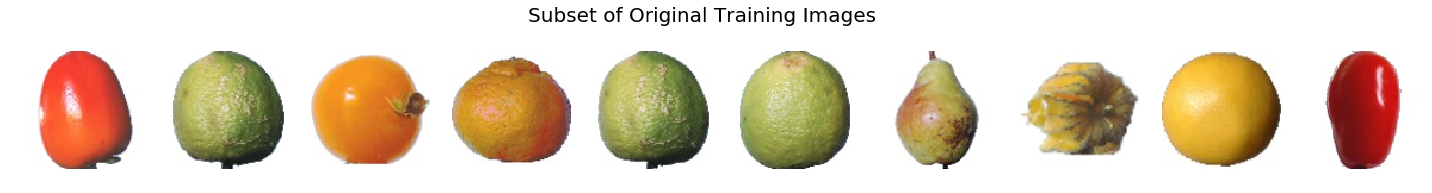

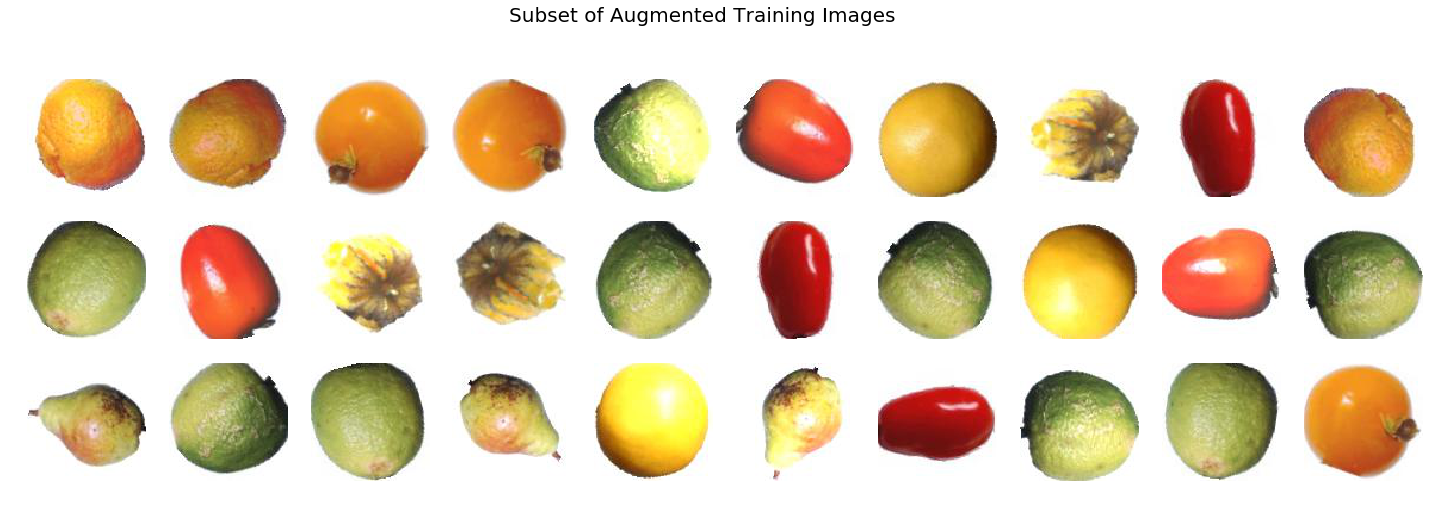

In [35]:
# visualize subset of training data
fig = plt.figure(figsize=(25,3))
for i in range(0, len(random_train_sample)):
    ax = fig.add_subplot(1, 10, i+1)
    ax.axis('off')
    ax.imshow(random_train_sample[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.axis('off')
plt.show()


images = []
for img_path in glob.glob('/tmp/augmented_data/*.jpeg'):
    images.append(mpimg.imread(img_path))
    
fig = plt.figure(figsize=(25, 10))
fig.suptitle('Subset of Augmented Training Images', fontsize=20)

columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

In [36]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])

In [37]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [38]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

In [39]:
# this method is used for representing the model plot, since imshow could plot big image with very small size..
#we use this function to display image with actual size
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

**Part4: Building and Testing model on the regular Test set**

In [40]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler

In [41]:
model = Sequential()
### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_generator.image_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(81, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 16)      208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 49, 49, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

In [42]:
from os.path import join, exists, expanduser
models_dir = expanduser(join('~', 'saved_models'))
if not exists(models_dir):
    os.makedirs(models_dir)

In [43]:
!ls ~

augmented_data	saved_models


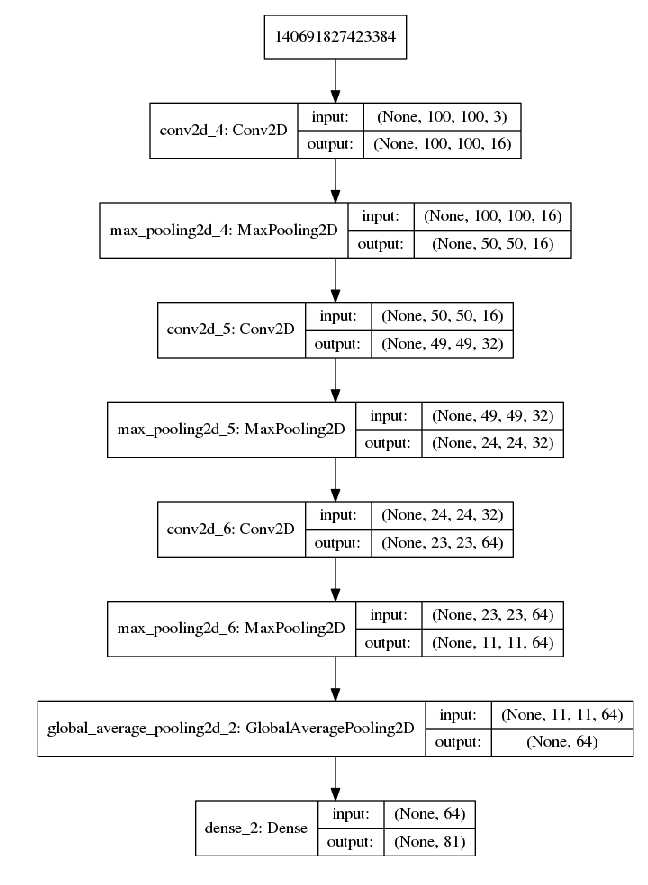

In [44]:
plot_model(model, to_file='/tmp/saved_models/model.png', show_shapes=True)
display_image_in_actual_size('/tmp/saved_models/model.png')

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=4)

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50
checkpointer = ModelCheckpoint(filepath='/tmp/saved_models/weights.best.augmented_data_cnn.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer,early_stopping],
        #callbacks=[checkpointer,early_stopping,lrate],
        verbose=1,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
969/969 [==============================] - 165s 171ms/step - loss: 2.3138 - acc: 0.3476 - val_loss: 1.4870 - val_acc: 0.5208

Epoch 00001: val_loss improved from inf to 1.48698, saving model to /tmp/saved_models/weights.best.augmented_data_cnn.hdf5
Epoch 2/50
969/969 [==============================] - 164s 169ms/step - loss: 1.0841 - acc: 0.6546 - val_loss: 1.0290 - val_acc: 0.6840

Epoch 00002: val_loss improved from 1.48698 to 1.02903, saving model to /tmp/saved_models/weights.best.augmented_data_cnn.hdf5
Epoch 3/50
969/969 [==============================] - 165s 170ms/step - loss: 0.8173 - acc: 0.7354 - val_loss: 0.8848 - val_acc: 0.7459

Epoch 00003: val_loss improved from 1.02903 to 0.88480, saving model to /tmp/saved_models/weights.best.augmented_data_cnn.hdf5
Epoch 4/50
969/969 [==============================] - 164s 170ms/step - loss: 0.6847 - acc: 0.7752 - val_loss: 0.8052 - val_acc: 0.7665

Epoch 00004: val_loss improved from 0.88480 to 0.80516, saving model to /tm

In [47]:
model.load_weights("/tmp/saved_models/weights.best.augmented_data_cnn.hdf5")

In [48]:
model.evaluate_generator(test_generator, test_generator.samples)

[0.20078831853925608, 0.9285148086762268]

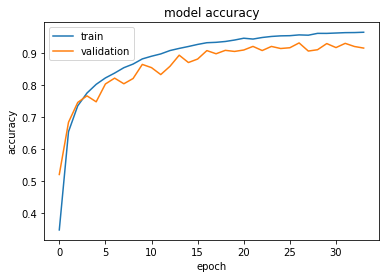

In [49]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

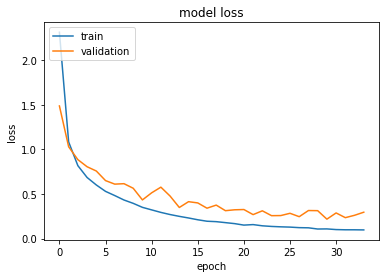

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Part5: Testing model on the real Test set**

In [51]:
def get_specific_class_img (class_name):
    root_directory = '../input/fruits/fruits-360_dataset/fruits-360/Training/'+ class_name + '/'
    img_path = glob.glob(os.path.join(root_directory,"*.jpg"))[0]
    return read_and_preprocess_img(img_path,"RGB",(100,100))

In [52]:
def model_predict(img):
    # obtain predicted vector
    predicted_vector = model.predict(img)
    # return fruit class that is predicted by the model
    return x1[np.argmax(predicted_vector)]

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


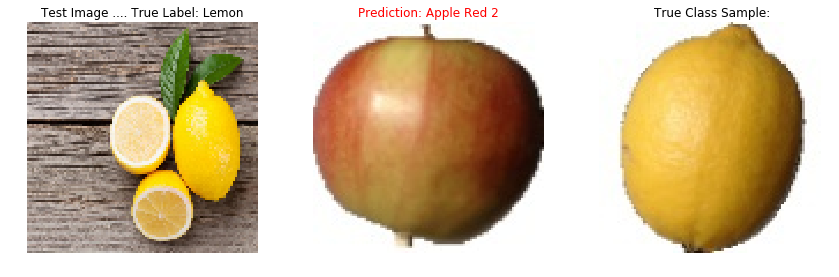

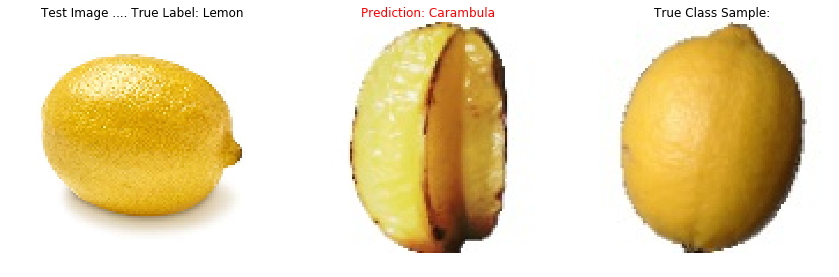

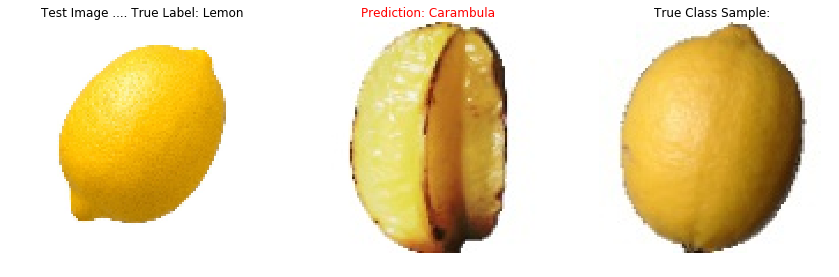

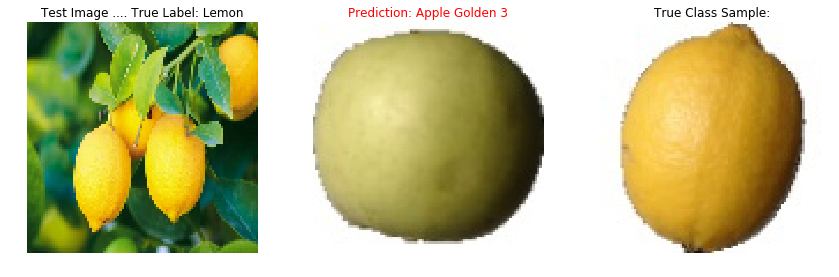

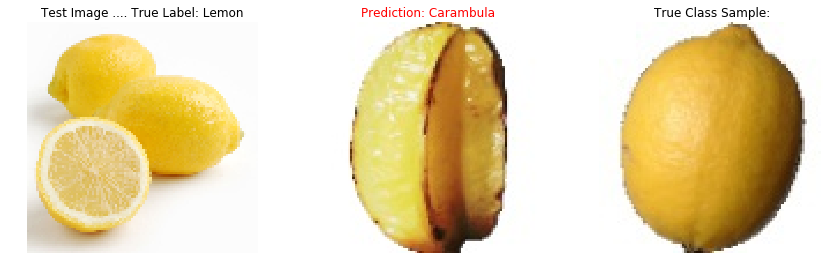

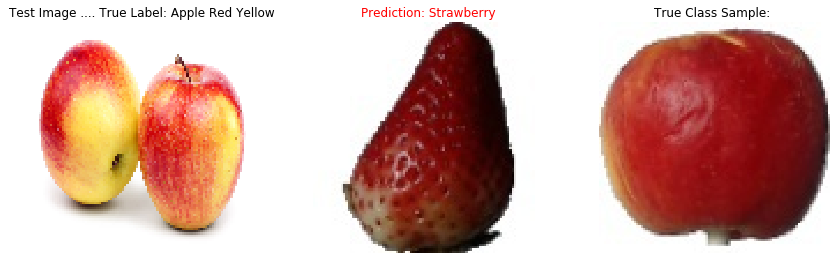

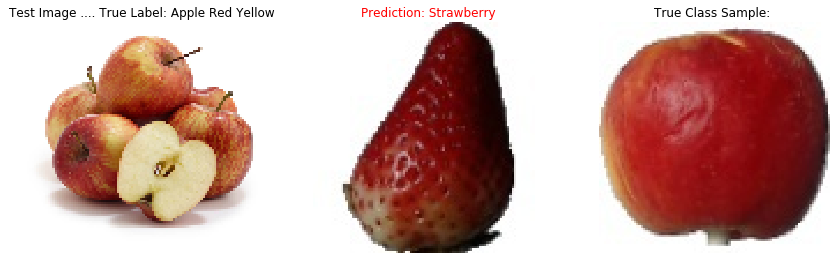

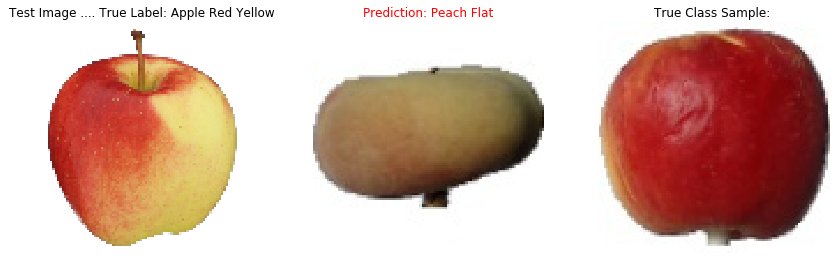

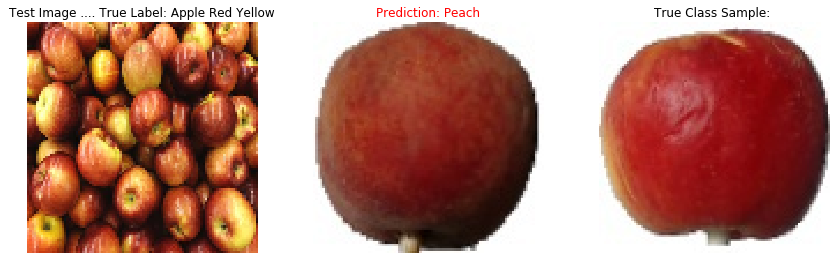

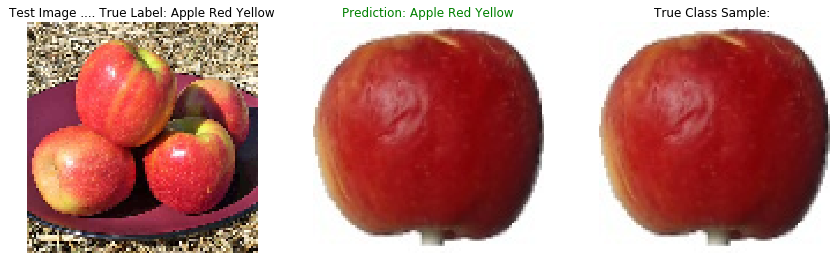

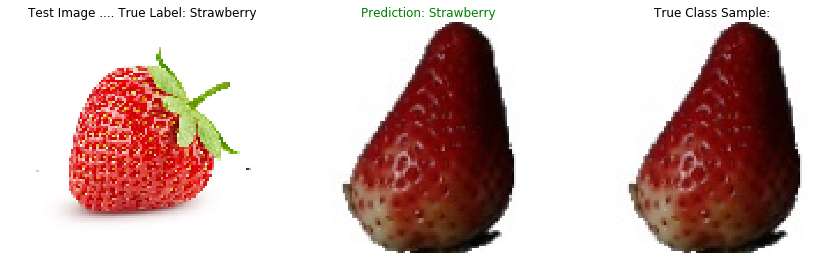

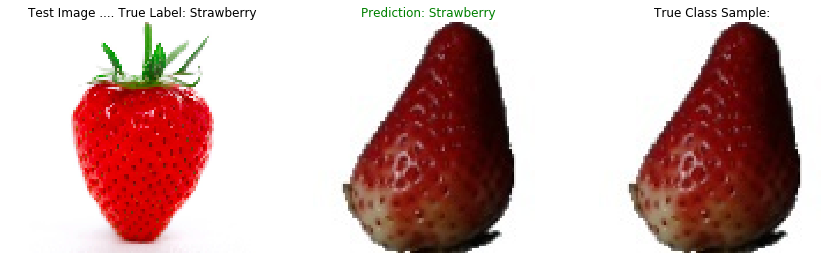

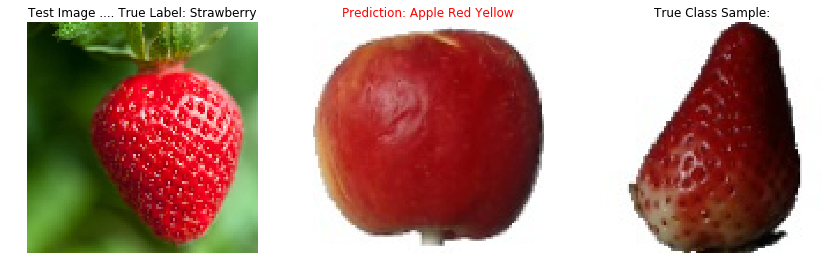

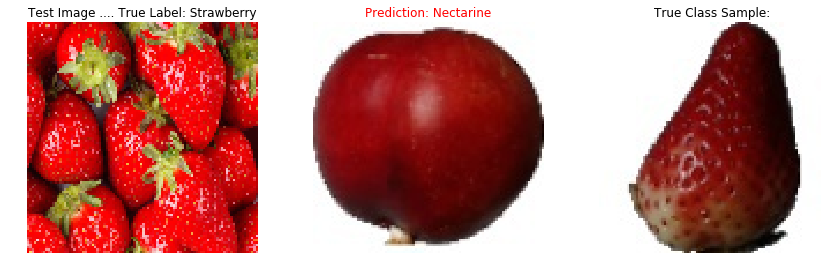

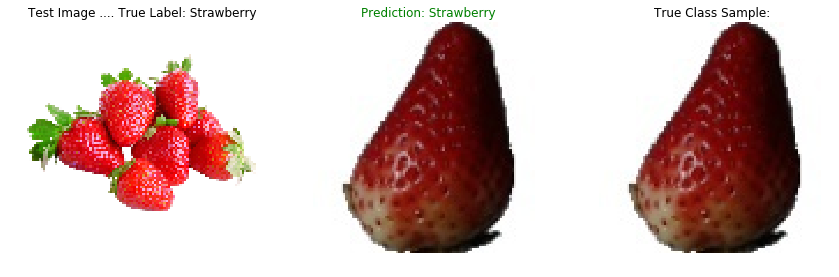

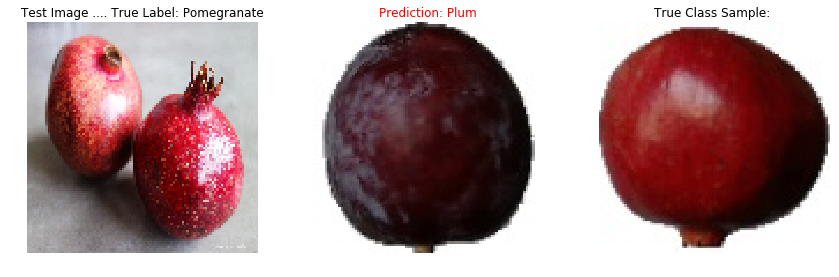

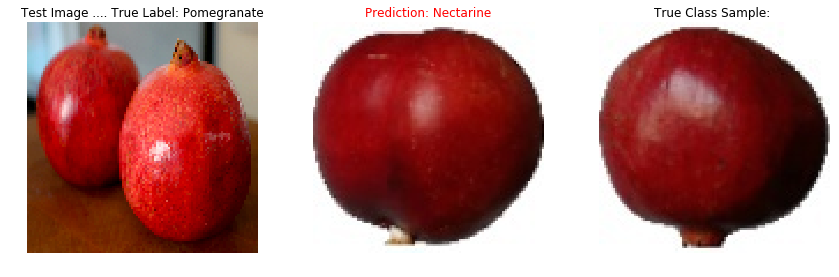

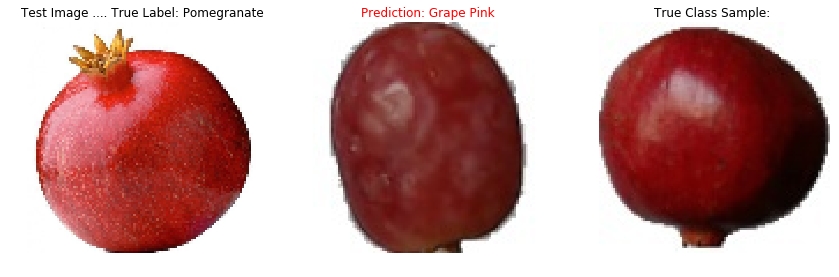

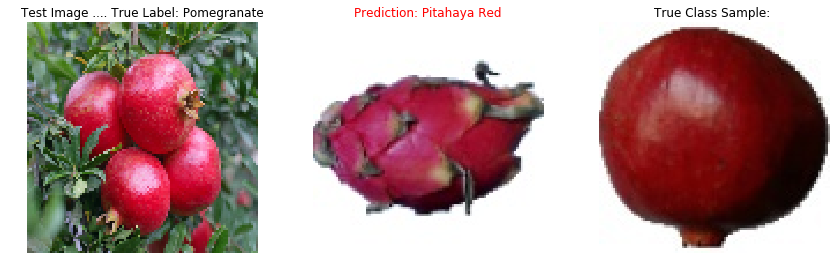

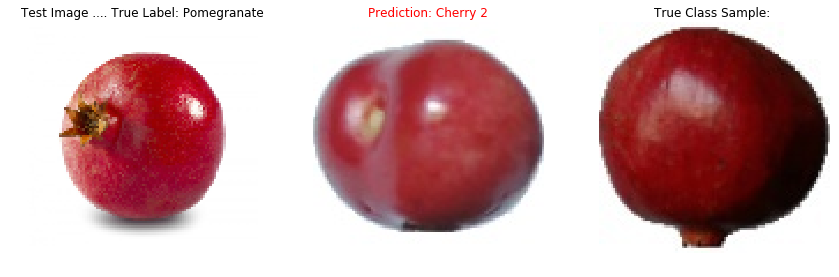

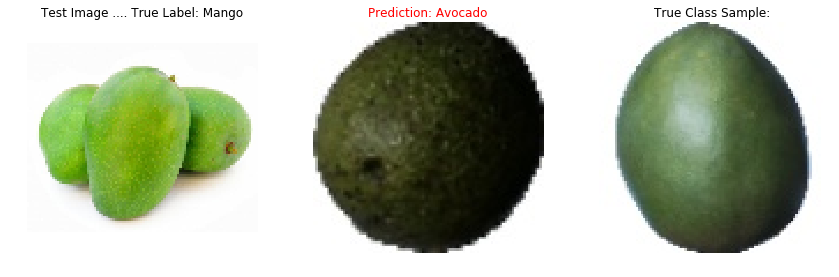

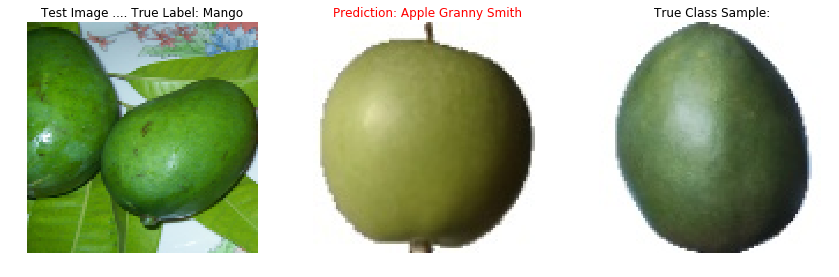

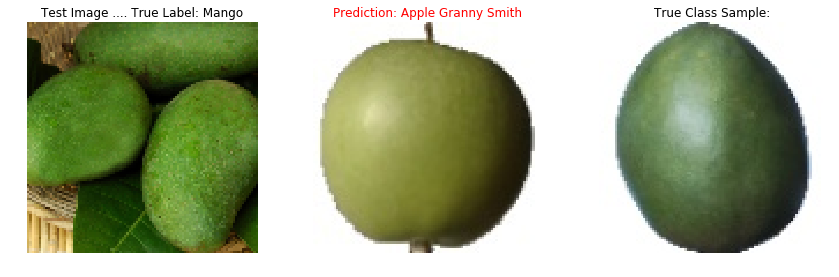

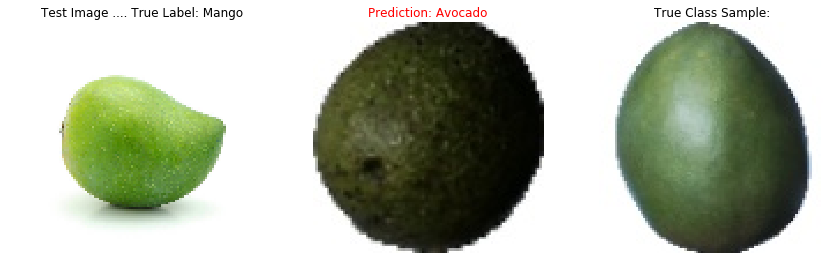

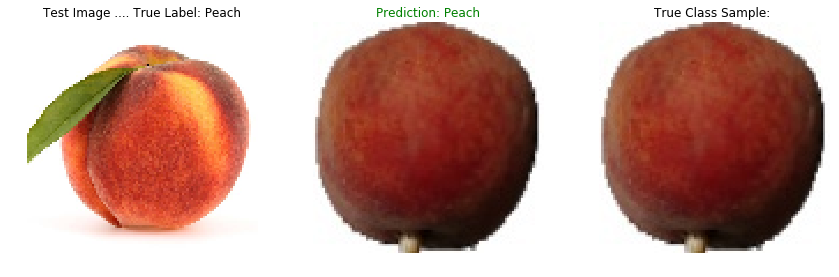

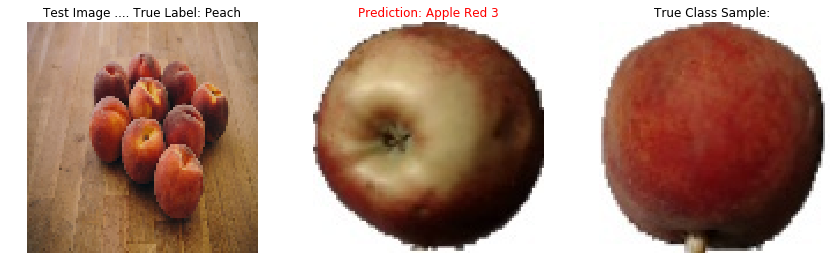

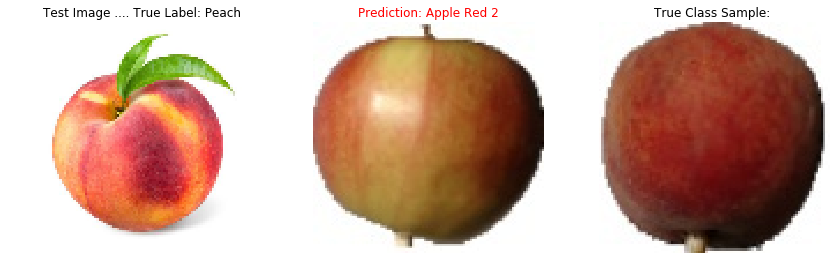

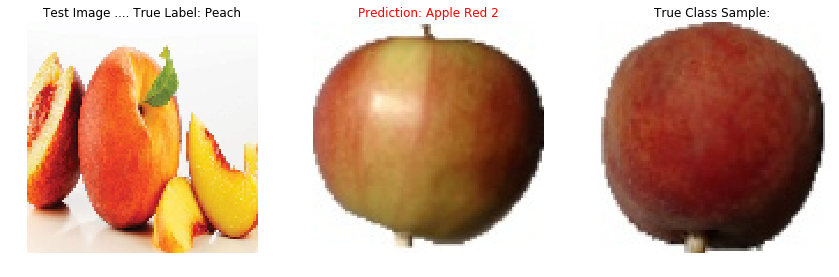

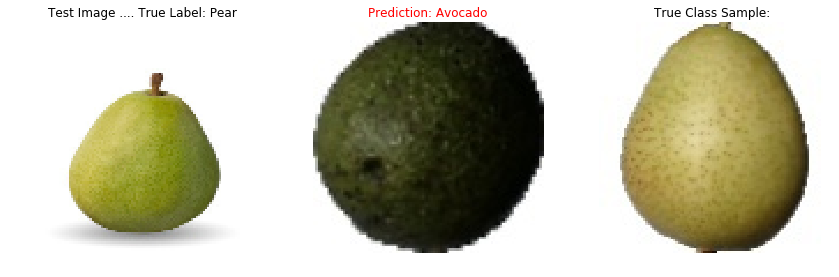

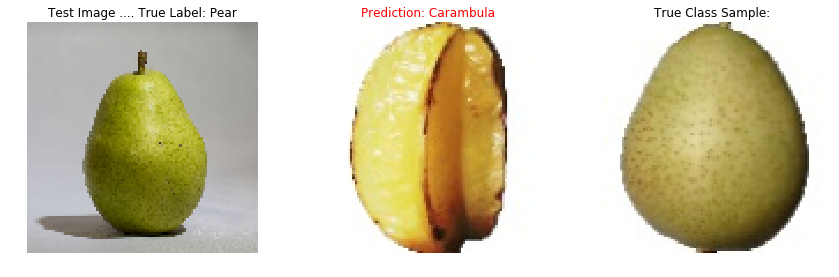

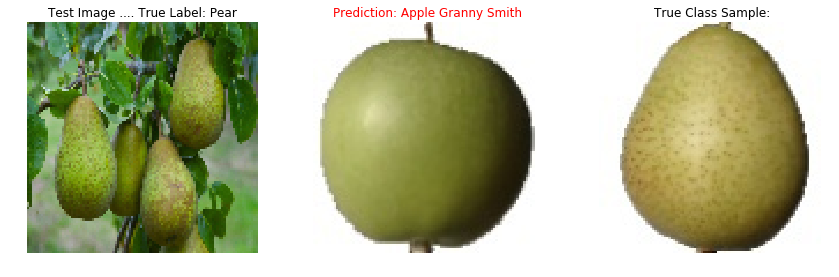

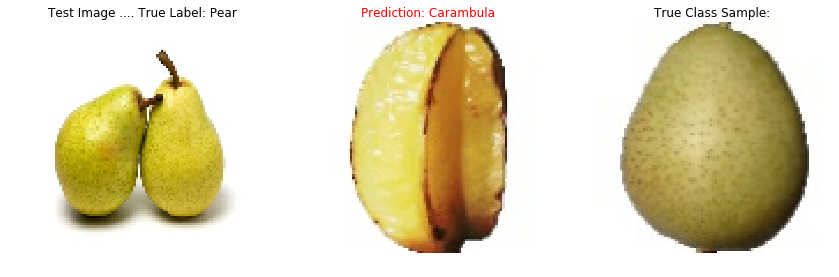

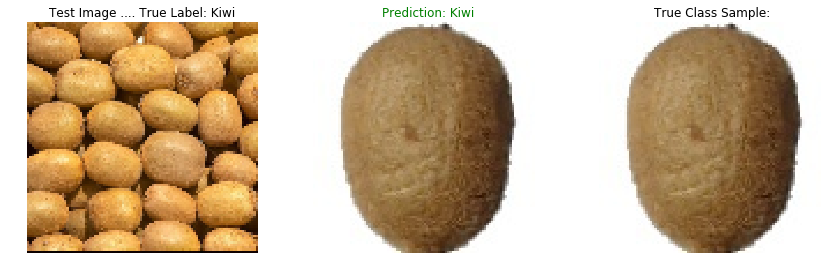

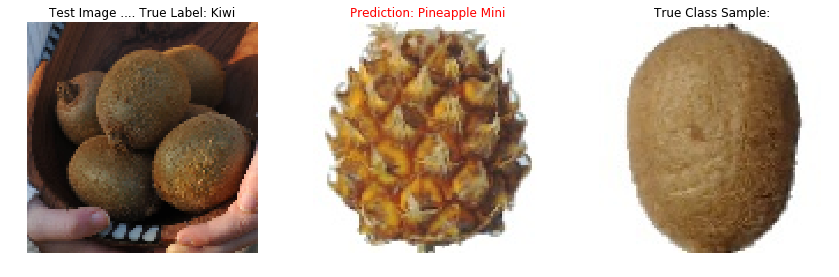

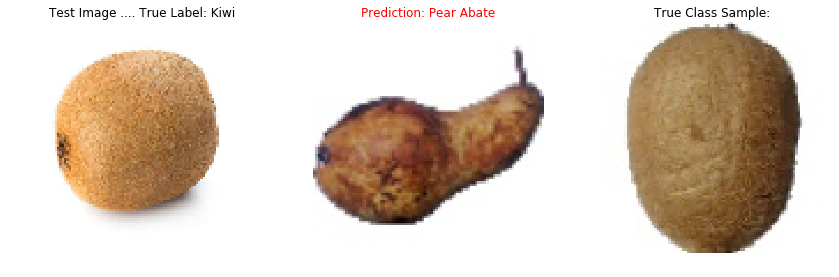

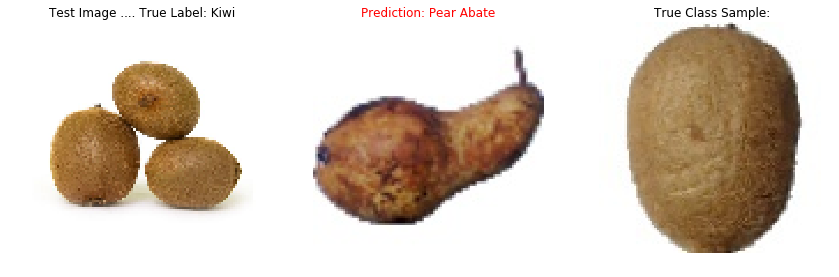

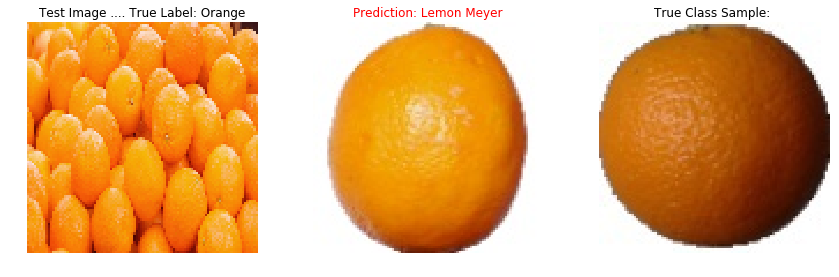

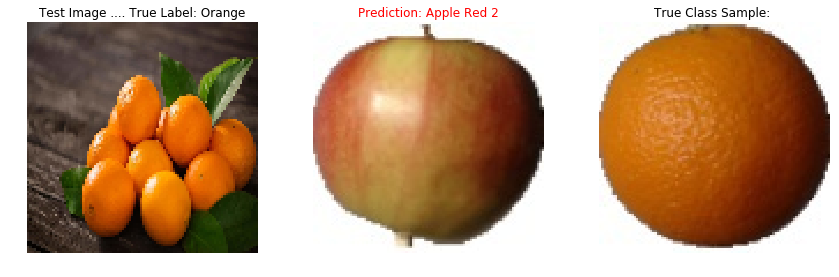

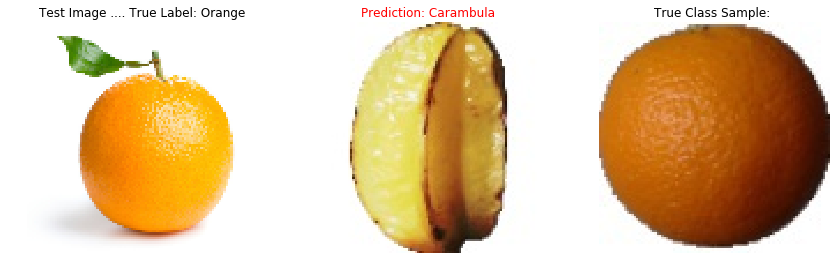

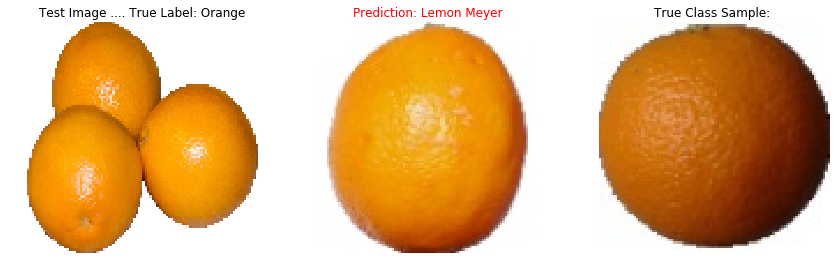

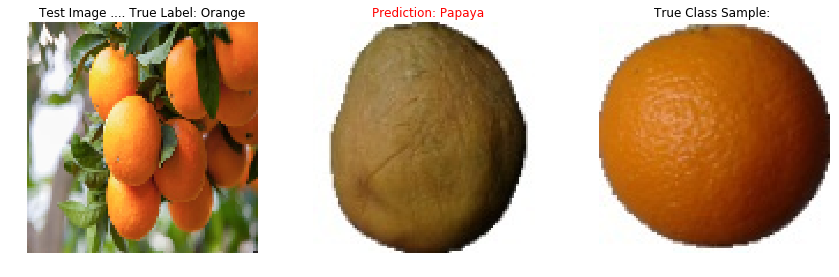

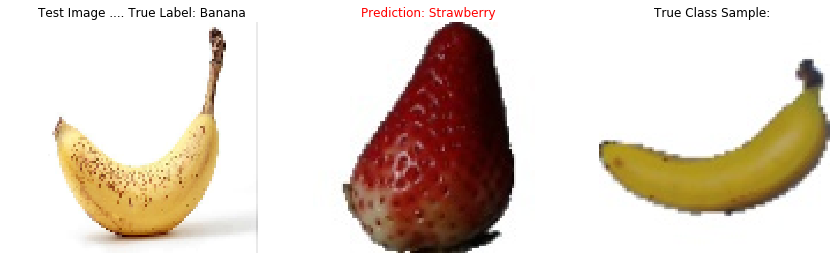

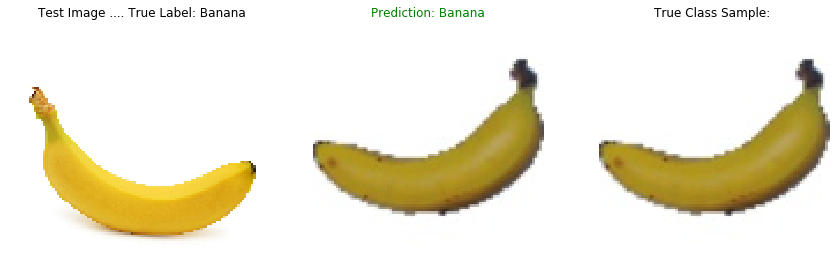

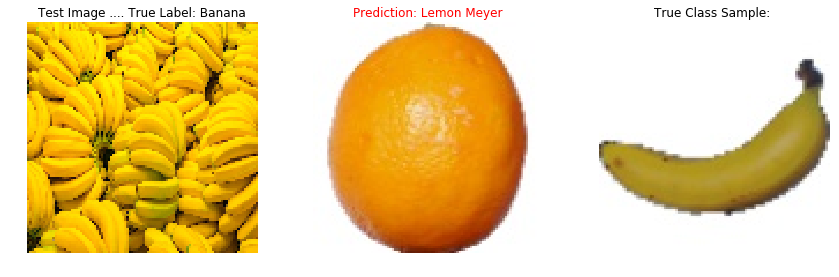

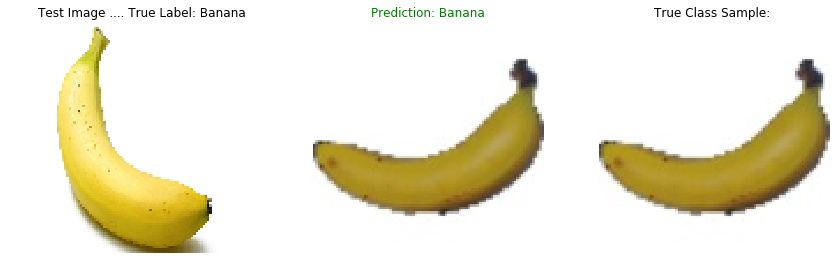

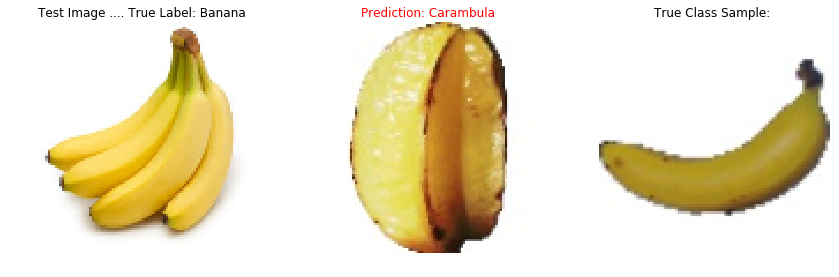

In [53]:
import os
unseen_test_data_dir = '../input/realtestdata/real-data/Capstone Data/'
right_pred = 0
#unseen_test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'
X_real_test,test_label = read_data(unseen_test_data_dir,"RGB",(100,100))
for i,img in enumerate(X_real_test):
    pred_class_name = model_predict(np.expand_dims(img, axis=0))
    true_label = test_label[i]
    pred_right = (true_label == pred_class_name)
    if pred_right:
        right_pred += 1
    f, (ax1,ax2,ax3) = plt.subplots(1,3)
    plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
    ax1.imshow(img)
    ax1.set_axis_off()    
    ax1.set_title('Test Image .... True Label: '+ true_label)
    ax2.imshow(get_specific_class_img(pred_class_name))
    ax2.set_axis_off()
    ax2.set_title('Prediction: '+ pred_class_name,color=("green" if pred_right else "red"))
    ax3.imshow(get_specific_class_img(true_label))
    ax3.set_axis_off()
    ax3.set_title('True Class Sample: ')

In [54]:
print("Model after augmenting Images predicted {} images right,accuracy = {}%".format(right_pred,(right_pred*100./50)))

Model after augmenting Images predicted 8 images right,accuracy = 16.0%
